In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 9.1

In [2]:
d = {'A':[0, 0, 10, 0, 0], 
     'B':[0, 1, 8, 1, 0], 
     'C':[0, 2, 6, 2, 0], 
     'D':[1, 2, 4, 2, 1], 
     'E':[2, 2, 2, 2, 2]}
p = pd.DataFrame(data=d)
d

{'A': [0, 0, 10, 0, 0],
 'B': [0, 1, 8, 1, 0],
 'C': [0, 2, 6, 2, 0],
 'D': [1, 2, 4, 2, 1],
 'E': [2, 2, 2, 2, 2]}

#### Code 9.2

In [3]:
p_norm = p/p.sum(0)
p_norm

,A,B,C,D,E
0,0.0,0.0,0.0,0.1,0.2
1,0.0,0.1,0.2,0.2,0.2
2,1.0,0.8,0.6,0.4,0.2
3,0.0,0.1,0.2,0.2,0.2
4,0.0,0.0,0.0,0.1,0.2


#### Code 9.3

In [4]:
def entropy(x):
    y = []
    for i in x:
        if i == 0:
            y.append(0)
        else: 
            y.append(i*np.log(i))
    h = -sum(y)
    return h
H = p_norm.apply(entropy, axis=0)
print(H)

A   -0.000000
B    0.639032
C    0.950271
D    1.470808
E    1.609438
dtype: float64


#### Code 9.4

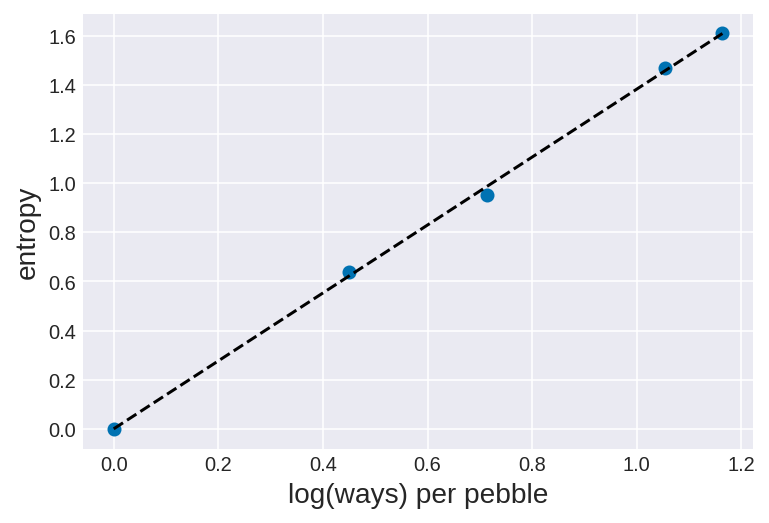

In [5]:
ways = [1, 90, 1260, 37800, 113400]
logwayspp = np.log(ways)/10
plt.plot(logwayspp, H, 'o')
plt.plot([0.0, max(logwayspp)], [0.0, max(H)],'--k')
plt.ylabel('entropy', fontsize=14);
plt.xlabel('log(ways) per pebble', fontsize=14)
plt.show()

#### Code 9.5

In [6]:
# Build list of the candidate distributions.
p = [[1/4, 1/4, 1/4, 1/4], 
     [2/6, 1/6, 1/6, 2/6], 
     [1/6, 2/6, 2/6, 1/6], 
     [1/8, 4/8, 2/8, 1/8]]

# Compute expected value of each. The sum of the multiplied entries is just a dot product.
p_ev = [np.dot(i,[0, 1, 1, 2]) for i in p]
print(p_ev)

[1.0, 1.0, 1.0, 1.0]


#### Code 9.6

In [7]:
# Compute entropy of each distribution
p_ent = [entropy(i) for i in p]
print(p_ent)

[1.3862943611198906, 1.3296613488547582, 1.3296613488547582, 1.2130075659799042]


#### Code 9.7

Suppose for our second example that the expected value must be instead 1.4 blue marbles in two draws.
This corresponds to p = 0.7. If we assume a binomial distribution we get the following probability density

In [8]:
p = 0.7
#p(white, white), p(white, blue), p(blue, white), p(blue, blue)
A = [(1-p)**2, p*(1-p), (1-p)*p, p**2]
print(A)

[0.09000000000000002, 0.21000000000000002, 0.21000000000000002, 0.48999999999999994]


#### Code 9.8

In [9]:
-np.sum(A*np.log(A))

1.221728604109787

#### Code 9.9

Explanation of formula below: 
* The expected value of a pmf is x1p1+x2p2+...
* The event we are interested in is getting a blue ball
* we defined the events as x1 -> 'ww', x2->'wb', x3->'bw' and x4->'bb'
* hence if the p1,p2,... are the probabilities of getting a blue ball we have:
  * 0*p1+1*p2+1*p3+2*p4 = expected number of blue balls = G
* but we cannot generate probabilities only some random numbers through `np.random.uniformnp.random.uniform`
* thus we need to include the normalization to in our definition of G
  * G = (z1*0+z2*1+z3*1+z4*2)/(z1+z2+z3+z4), where z1,...,z4 are random numbers
* solving for z4 we get (G * (z1+z2+z3) - z2 - z3) / (2 - G)

In [10]:
def sim_p(G=1.4):
    x123 = np.random.uniform(size=3)
    x4 = (G * np.sum(x123) - x123[1] - x123[2]) / (2 - G)
    x1234 = np.concatenate((x123, [x4]))
    z = np.sum(x1234)
    p = x1234 / z
    return - np.sum(p * np.log(p)), p

#### Code 9.10

In [11]:
H = []
p = np.zeros((10**5, 4))
for rep in range(10**5):
    h, p_ = sim_p()
    H.append(h)
    p[rep] = p_

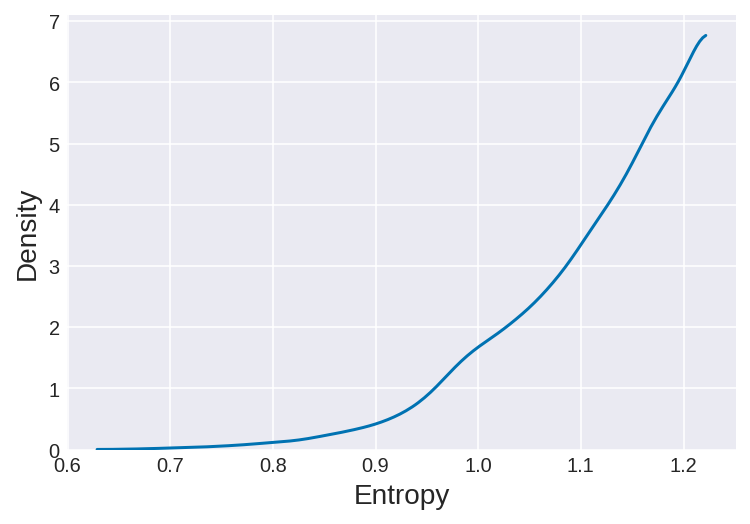

In [12]:
pm.kdeplot(H)
plt.xlabel('Entropy', fontsize=14)
plt.ylabel('Density', fontsize=14);

#### Code 9.12

In [13]:
np.max(H)

1.221727280810346

#### Code 9.13

In [14]:
p[np.argmax(H)]

array([0.08995015, 0.20952827, 0.21057142, 0.48995015])

In [15]:
p[np.argmax(H)] - A

array([-4.98469774e-05, -4.71728330e-04,  5.71422285e-04, -4.98469774e-05])

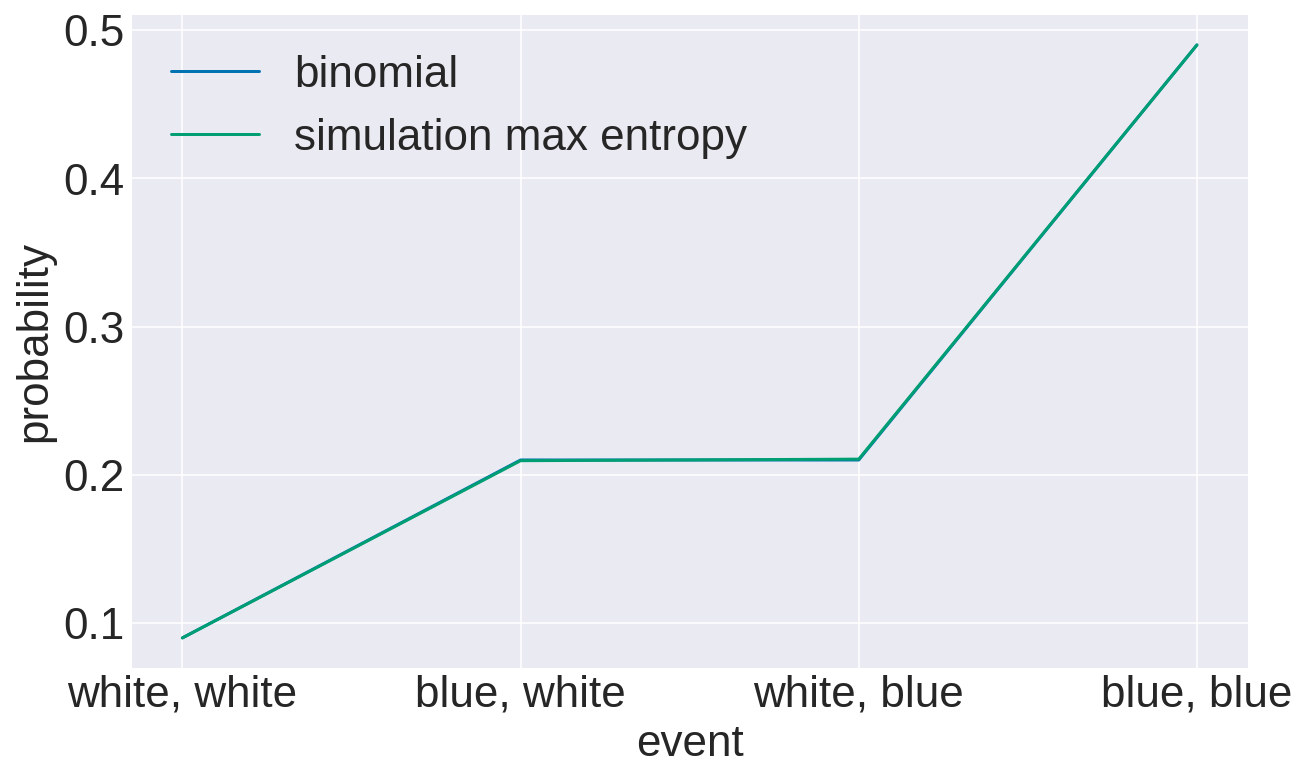

In [16]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(A, label='binomial')
ax.plot(p[np.argmax(H)], label='simulation max entropy');
ax.set_ylabel('probability')
ax.set_xlabel('event')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['white, white','blue, white', 'white, blue', 'blue, blue'])
ax.legend();

In [17]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.7.2
IPython 7.6.1
PyMC3 3.6
NumPy 1.16.0
Pandas 0.23.4
SciPy 1.2.0
Matplotlib 3.0.2



/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
